# CARLA Trajectory Tuning with Direct Preference Optimization (DPO)

This notebook demonstrates how to apply **Direct Preference Optimization (DPO)** to autonomous driving trajectory optimization using synthetic CARLA-like data. 

> **How to Run:**  
> Execute each cell in order. The notebook will generate synthetic data, train models, and display results. No real CARLA data is required.

## 1. Overview

We'll implement a complete DPO pipeline that:
1. **Generates synthetic driving trajectories** with different behavioral patterns (smooth, jittery, aggressive, centered)
2. **Creates preference pairs** based on trajectory smoothness and lane centering
3. **Trains a neural policy** using DPO to learn human preferences for smooth, centered driving
4. **Evaluates the learned policy** on trajectory quality metrics

This extends RLHF concepts beyond language models to robotics and autonomous systems.

## 2. Key Components
- **Synthetic Data Generation**: CARLA-like road scenes with car movement
- **Preference Scoring**: Heuristic combining trajectory smoothness and lane centering
- **DPO Training**: Direct preference optimization without explicit reward modeling
- **Policy Architecture**: CNN frame encoder + simple policy network

Let's start by installing dependencies:

In [1]:
!pip install -q imageio torch torchvision tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00


### Next, we import all required libraries for data generation, visualization, and model training.

In [2]:

import os
import random
import glob
import math
from pathlib import Path
from tqdm import tqdm
import numpy as np
import imageio
import matplotlib.pyplot as plt
from IPython.display import HTML, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from PIL import Image, ImageDraw

## 3. Configuration and Setup

Setting up the training parameters, device configuration, and data directories.

In [3]:
# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_H, IMG_W = 64, 64           # per-frame size
TRAJ_LEN = 20                   # frames per trajectory (short)
NUM_TRAJS = 250                 # number of trajectories in dataset (small)
PAIRS_NUM = 400                 # number of preference pairs
BATCH = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Directories (you can replace these with your paths)
REAL_CLIPS_DIR = "carla_clips"          # for real mp4 frames or folder-per-episode with frames
REAL_LOGS_DIR = "carla_logs"            # optional: per-episode .npz with actions or action sequences
SYNTH_DIR = "synthetic_carla_data"      # fallback generated data
OUT_DIR = "offline_carla_demo_out"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(SYNTH_DIR, exist_ok=True)

# Simple image->tensor transform
to_tensor = transforms.Compose([
    transforms.ToTensor(),                      # C,H,W in [0,1]
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # normalize
])

# Utility: show GIF inline from path (works for animated GIFs)
from IPython.display import HTML
import base64

def display_gif(path, width=320):
    if os.path.exists(path):
        with open(path, "rb") as f:
            data = f.read()
        b64 = base64.b64encode(data).decode("ascii")
        return HTML(f'<img src="data:image/gif;base64,{b64}" width="{width}">')
    else:
        print("GIF not found:", path)

## 4. Synthetic Data Generation

Since we don't have access to real CARLA data, we'll generate synthetic driving scenes that mimic front-camera views from an autonomous vehicle. Each scene includes:

- **Road with lane markings**: Simulating a highway environment
- **Ego vehicle marker**: Red circle representing our car's position
- **Variable positioning**: Car moves laterally based on different driving behaviors

### Trajectory Types:
- **Smooth**: Gentle lateral movements with small random drift
- **Jittery**: Large random jumps simulating erratic driving  
- **Aggressive**: Binary left/right movements
- **Centered**: Attempts to stay in lane center with correction behavior

In [4]:
# Synthetic generator that mimics CARLA-like front-camera frames and discrete steering actions:
# discrete actions: 0 = left, 1 = straight, 2 = right (simplified)

def render_synthetic_frame(x_offset, y_offset, speed=1.0, img_h=IMG_H, img_w=IMG_W):
    """Render a simple synthetic road frame: road + lane divider + car center offset by x_offset,y_offset"""
    img = Image.new("RGB", (img_w, img_h), (100, 120, 120))
    draw = ImageDraw.Draw(img)
    # road rectangle
    draw.rectangle([int(img_w*0.1), 0, int(img_w*0.9), img_h], fill=(40,40,40))
    # lane center line (dashed)
    for i in range(0, img_h, 8):
        draw.rectangle([img_w//2-2, i, img_w//2+2, i+4], fill=(200,200,200))
    # add roadside color
    draw.rectangle([0,0,int(img_w*0.1),img_h], fill=(30,100,30))
    draw.rectangle([int(img_w*0.9),0,img_w,img_h], fill=(30,100,30))
    # draw ego-car marker near bottom, offset by x_offset,y_offset
    cx = img_w//2 + int(x_offset)
    cy = int(img_h*0.8 + y_offset)
    draw.ellipse([cx-5, cy-5, cx+5, cy+5], fill=(255,60,60))
    # Add a debug print to verify x_offset is actually changing
    if abs(x_offset) > 0.1:  # Only print when there's actual movement
        print(f"Car at x_offset={x_offset:.1f}, cx={cx}")
    return np.array(img)


def gen_synth_traj(kind="smooth", traj_len=TRAJ_LEN):
  x = 0.0
  y = 0.0
  frames = []
  actions = []
  for t in range(traj_len):
    if kind == "smooth":
      dx = np.clip(np.random.randn()*0.8, -2,2)  # gentle drift
    elif kind == "jittery":
      dx = np.random.randint(-25, 26)  # large jumps
    elif kind == "aggressive":
      dx = np.random.choice([-8, 8])
    elif kind == "centered":
      dx = int((0 - x)*0.2) + np.random.randint(-1,2)
    else:
      dx = np.random.randint(-4, 5)
    # x = float(np.clip(x + dx, -20, 20))
    x = float(x + dx)
    action = 0 if dx < -0.5 else 2 if dx > 0.5 else 1
    actions.append(int(action))
    frames.append(render_synthetic_frame(x_offset=x, y_offset=y))
  return frames, np.array(actions, dtype=np.int64)


# optional: generate a small folder of synthetic clips for inspection
def create_synth_dataset(out_dir=SYNTH_DIR, n=150):
    os.makedirs(out_dir, exist_ok=True)
    kinds = ["smooth","jittery","aggressive","centered"]
    meta = []
    for i in range(n):
        k = random.choice(kinds)
        frames, actions = gen_synth_traj(k)
        clip_dir = Path(out_dir) / f"clip_{i:04d}"
        clip_dir.mkdir(parents=True, exist_ok=True)
        for t, f in enumerate(frames):
            Image.fromarray(f).save(clip_dir / f"frame_{t:03d}.png")
        np.save(clip_dir / "actions.npy", actions)
        meta.append((str(clip_dir), k))
    return meta

# Create synthetic dataset if real dataset not found
if not os.path.exists(REAL_CLIPS_DIR):
    print("No real CARLA clips found; generating synthetic dataset...")
    synth_meta = create_synth_dataset(SYNTH_DIR, n=NUM_TRAJS)
else:
    synth_meta = []


No real CARLA clips found; generating synthetic dataset...
Car at x_offset=0.4, cx=32
Car at x_offset=0.3, cx=32
Car at x_offset=0.8, cx=32
Car at x_offset=2.0, cx=34
Car at x_offset=1.8, cx=33
Car at x_offset=1.6, cx=33
Car at x_offset=2.9, cx=34
Car at x_offset=3.5, cx=35
Car at x_offset=3.2, cx=35
Car at x_offset=3.6, cx=35
Car at x_offset=3.2, cx=35
Car at x_offset=2.8, cx=34
Car at x_offset=3.0, cx=35
Car at x_offset=1.5, cx=33
Car at x_offset=0.1, cx=32
Car at x_offset=-0.3, cx=32
Car at x_offset=-1.1, cx=31
Car at x_offset=-0.9, cx=32
Car at x_offset=-1.6, cx=31
Car at x_offset=-2.7, cx=30
Car at x_offset=1.2, cx=33
Car at x_offset=1.0, cx=32
Car at x_offset=1.0, cx=33
Car at x_offset=-0.5, cx=32
Car at x_offset=-0.4, cx=32
Car at x_offset=-1.4, cx=31
Car at x_offset=-1.1, cx=31
Car at x_offset=-1.5, cx=31
Car at x_offset=-1.8, cx=31
Car at x_offset=-2.3, cx=30
Car at x_offset=-0.8, cx=32
Car at x_offset=-0.8, cx=32
Car at x_offset=-1.6, cx=31
Car at x_offset=-1.0, cx=32
Car at 

## 5. Visualizing Different Trajectory Types

Let's generate and visualize examples of different driving behaviors to understand our synthetic data:

Car at x_offset=-0.3, cx=32
Car at x_offset=-0.3, cx=32
Car at x_offset=-0.4, cx=32
Car at x_offset=-1.8, cx=31
Car at x_offset=-0.6, cx=32
Car at x_offset=-0.5, cx=32
Car at x_offset=-0.2, cx=32
Car at x_offset=0.6, cx=32
Car at x_offset=-0.2, cx=32
Car at x_offset=0.1, cx=32
Car at x_offset=0.6, cx=32
Car at x_offset=-1.1, cx=31
Car at x_offset=-1.2, cx=31
Car at x_offset=-1.7, cx=31
Car at x_offset=-1.3, cx=31
Car at x_offset=-0.9, cx=32
Car at x_offset=-1.5, cx=31
Car at x_offset=-2.1, cx=30
Smooth trajectory example:


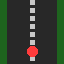

Car at x_offset=-5.0, cx=27
Car at x_offset=-23.0, cx=9
Car at x_offset=-44.0, cx=-12
Car at x_offset=-44.0, cx=-12
Car at x_offset=-54.0, cx=-22
Car at x_offset=-44.0, cx=-12
Car at x_offset=-42.0, cx=-10
Car at x_offset=-39.0, cx=-7
Car at x_offset=-18.0, cx=14
Car at x_offset=-32.0, cx=0
Car at x_offset=-21.0, cx=11
Car at x_offset=-17.0, cx=15
Car at x_offset=-20.0, cx=12
Car at x_offset=-30.0, cx=2
Car at x_offset=-42.0, cx=-10
Car at x_offset=-58.0, cx=-26
Car at x_offset=-77.0, cx=-45
Car at x_offset=-58.0, cx=-26
Car at x_offset=-47.0, cx=-15
Car at x_offset=-44.0, cx=-12
Jittery trajectory example:


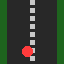

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image as IPyImage, display

def show_gif_inline(frames, fps=6):
  """Display an in-memory list of RGB frames as an inline GIF."""
  # Ensure uint8 frames
  frames_uint8 = [(f if f.dtype == np.uint8 else (f*255).astype(np.uint8)) for f in frames]
  gif_bytes = imageio.mimsave('<bytes>', frames_uint8, fps=fps, format='GIF', loop=0, return_bytes=True)
  display(Image(data=gif_bytes))

# Generate and show one smooth trajectory
frames_smooth, _ = gen_synth_traj(kind="smooth")
print("Smooth trajectory example:")
show_gif_inline(frames_smooth)

# Generate and show one jittery trajectory
frames_jittery, _ = gen_synth_traj(kind="jittery")
print("Jittery trajectory example:")
show_gif_inline(frames_jittery)


## 6. Data Loading and Preprocessing

Now we'll load our synthetic trajectory data into memory for training. Each trajectory consists of:
- **Frames**: Sequential images showing the car's movement
- **Actions**: Corresponding steering commands (left=0, straight=1, right=2)

In [7]:
def load_clip_folder(clip_dir):
    # expects frames named frame_000.png ... and actions.npy
    clip_dir = Path(clip_dir)
    frame_files = sorted(list(clip_dir.glob("frame_*.png")))
    frames = []
    for f in frame_files[:TRAJ_LEN]:
        img = Image.open(f).resize((IMG_W, IMG_H))
        frames.append(np.array(img))
    # load actions if present
    actions_path = clip_dir / "actions.npy"
    actions = None
    if actions_path.exists():
        actions = np.load(actions_path)[:TRAJ_LEN]
    else:
        # if no action log, try to infer from frames (fallback): simple heuristic
        actions = np.ones(TRAJ_LEN, dtype=np.int64)  # all straight
    return frames, actions

# Build dataset list either from real data or synthetic folder
clip_dirs = []
if os.path.exists(REAL_CLIPS_DIR):
    # find subfolders
    clip_dirs = [str(p) for p in Path(REAL_CLIPS_DIR).glob("*/") if p.is_dir()]
if not clip_dirs:
    # use synthetic
    clip_dirs = [str(p) for p in Path(SYNTH_DIR).glob("clip_*") if p.is_dir()]

print(f"Using {len(clip_dirs)} clips for dataset")


Using 250 clips for dataset


Loaded clips: 250



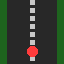

In [8]:
# read N clips into memory (keep small for speed)
DATA_N = min(len(clip_dirs), NUM_TRAJS)
clips = []
for cd in clip_dirs[:DATA_N]:
    frames, actions = load_clip_folder(cd)
    # ensure correct shape and dtype
    frames = np.stack(frames)[:TRAJ_LEN]  # (T,H,W,C)
    actions = np.array(actions, dtype=np.int64)[:TRAJ_LEN]
    clips.append((frames, actions))

print("Loaded clips:", len(clips))
# visualize first clip frames as a tiny sample GIF
sample_clip_path = os.path.join(OUT_DIR, "sample_clip.gif")
imageio.mimsave(sample_clip_path, clips[0][0], fps=8)
display_gif(sample_clip_path, width=360)


## 7. Preference Scoring: Defining "Good" Driving

We need to define what makes one trajectory better than another. Our scoring function combines:

### 1. **Smoothness Score** (70% weight)
- Measures how consistent the car's lateral position is across frames
- Penalizes large frame-to-frame movements
- Higher scores = smoother driving

### 2. **Centering Score** (30% weight)  
- Measures how close the car stays to the lane center
- Penalizes deviation from the middle of the road
- Higher scores = better lane keeping

### Technical Implementation:
- Uses **red pixel detection** to reliably find the car marker
- More robust than brightness-based detection which can confuse lane lines with the car

In [ ]:
# Preference scoring heuristic (synthetic human): prefer small framewise lateral changes (smoothness)
def traj_smoothness_score(frames):
    # compute center-of-mass y coordinate per frame and measure mean absolute change
    ys = []
    for f in frames:
        im = np.array(f)
        # Find red pixels (car marker) - more reliable than brightness
        red_mask = (im[:,:,0] > 200) & (im[:,:,1] < 100) & (im[:,:,2] < 100)
        if red_mask.any():
            red_positions = np.where(red_mask)
            # Use centroid of red pixels
            cy_mean = np.mean(red_positions[1])  # horizontal centroid
            ys.append(cy_mean)
        else:
            ys.append(32.0)  # fallback to center if no red found
    ys = np.array(ys, dtype=np.float32)
    smooth = -np.mean(np.abs(np.diff(ys)))/ IMG_W  # Normalize by image width      # higher is smoother
    # center_bias = -np.mean(np.abs(ys - IMG_W/2)) # closer to center better
    center_bias = -np.mean(np.abs(ys - IMG_W/2)) / (IMG_W/2)  # Normalize by half-width
    return 0.7*smooth + 0.3*center_bias

# Generate pairs
pairs = []
labels = []
all_indices = list(range(len(clips)))
for _ in range(PAIRS_NUM):
    i, j = random.sample(all_indices, 2)
    fi, ai = clips[i]
    fj, aj = clips[j]
    si = traj_smoothness_score(fi)
    sj = traj_smoothness_score(fj)
    # label 0 if A preferred, 1 if B preferred
    label = 0 if si > sj else 1
    pairs.append((i,j))
    labels.append(label)
print("Generated", len(pairs), "preference pairs")


Generated 400 preference pairs


## Neural Network Architecture

Our DPO system uses two main components:

### 1. **Frame Encoder**: 
- Small CNN that converts 64x64 RGB frames into feature embeddings
- Processes visual information about road scenes

### 2. **Policy Network**:
- Maps frame embeddings to action probabilities (left/straight/right)
- Represents the driving policy we want to optimize

We'll first train these networks with **behavior cloning** on our synthetic action data, then fine-tune with **DPO** using preference pairs.

In [10]:
# Use a small CNN encoder (or ResNet18) to extract per-frame embeddings
# For speed, we'll use a small lightweight CNN we define here.
class SmallFrameEncoder(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten(),
            nn.Linear(32*4*4, out_dim), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

frame_encoder = SmallFrameEncoder(out_dim=128).to(DEVICE)

# Policy model (reference policy) that maps frame-embedding -> action logits
class SimplePolicy(nn.Module):
    def __init__(self, emb_dim=128, num_actions=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(emb_dim, 64), nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, emb):
        return self.model(emb)  # logits

policy_ref = SimplePolicy(emb_dim=128, num_actions=3).to(DEVICE)

# Prepare dataset of (frame_embedding, action) for behavior cloning
frame_tensors = []
action_tensors = []
for frames, actions in clips:
    # preprocess frames
    frames_t = np.transpose(frames.astype(np.float32)/255.0, (0,3,1,2))  # (T,C,H,W)
    frame_tensors.append(torch.tensor(frames_t))
    action_tensors.append(torch.tensor(actions, dtype=torch.long))

# Flatten across trajectories: we'll train encoder + ref policy to predict action per frame
frames_all = torch.cat(frame_tensors, dim=0)  # (N*T, C, H, W)
actions_all = torch.cat(action_tensors, dim=0)  # (N*T,)
print("Frames total:", frames_all.shape, "Actions total:", actions_all.shape)


Frames total: torch.Size([5000, 3, 64, 64]) Actions total: torch.Size([5000])


We now train a baseline policy using supervised learning on synthetic trajectories.

## Step 1: Behavior Cloning (Supervised Learning)

Before applying DPO, we need a reasonable baseline policy. We'll train our frame encoder and policy network to predict the correct steering action for each frame using supervised learning.

This gives us:
- A **reference policy** for DPO training
- Pretrained networks that understand basic driving patterns

In [11]:
# Train encoder + policy_ref on frame->action supervised data (behavior cloning)
bc_epochs = 3
bc_batch = 64
dataset = torch.utils.data.TensorDataset(frames_all, actions_all)
loader = DataLoader(dataset, batch_size=bc_batch, shuffle=True)

opt = optim.Adam(list(frame_encoder.parameters()) + list(policy_ref.parameters()), lr=3e-4)
for ep in range(bc_epochs):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        emb = frame_encoder(xb)
        logits = policy_ref(emb)
        loss = F.cross_entropy(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    print(f"BC epoch {ep+1}/{bc_epochs} loss: {total_loss/len(dataset):.4f}")

# Save a copy of reference policy logits function (we'll use it for KL)
policy_ref.eval()
frame_encoder.eval()


BC epoch 1/3 loss: 1.0846
BC epoch 2/3 loss: 1.0531
BC epoch 3/3 loss: 0.9862


SmallFrameEncoder(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(4, 4))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
  )
)

With a reference policy in place, we fine-tune our model using Direct Preference Optimization (DPO) based on preference pairs.

## Step 2: Direct Preference Optimization (DPO) Training

Now comes the main event! We'll fine-tune our policy using preference pairs based on trajectory quality.

### DPO Key Concepts:
- **No explicit reward model**: DPO directly optimizes policy preferences
- **Reference policy**: Uses our behavior cloning model as baseline
- **Preference pairs**: Compares trajectories A vs B based on smoothness scores
- **Loss function**: Binary cross-entropy on preference probability

### Training Process:
1. Sample pairs of trajectories from our dataset
2. Score each trajectory using our preference function
3. Train policy to prefer higher-scoring trajectories
4. Include KL penalty to prevent deviation from reference policy

In [12]:
# We'll create a trainable policy initialized from policy_ref and fine-tune it using pairs.
policy_theta = SimplePolicy(emb_dim=128, num_actions=3).to(DEVICE)
# initialize with reference weights
policy_theta.load_state_dict(policy_ref.state_dict())

# DPO hyperparams
dpo_epochs = 6
dpo_lr = 1e-3
kl_coef = 0.02     # small KL penalty towards ref
temp = 1.0         # temperature for logistic/sigmoid

opt_theta = optim.Adam(policy_theta.parameters(), lr=dpo_lr)

def trajectory_logprob(policy, frames_tensor, actions_np):
    """
    Compute the log-probability of a trajectory's actions under the given policy.
    frames_tensor: numpy array of shape (T, H, W, C), dtype uint8 or float
    actions_np: numpy array of shape (T,) with action indices
    """
    # Normalize to [0,1] and reorder to (T, C, H, W)
    f_np = frames_tensor.astype(np.float32) / 255.0
    f_torch = torch.tensor(np.transpose(f_np, (0, 3, 1, 2)), dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        T, C, H, W = f_torch.shape
        emb = frame_encoder(f_torch)   # (T, emb)
        logits = policy(emb)           # (T, num_actions)
        logp = F.log_softmax(logits, dim=1)  # (T, num_actions)
        idx = torch.tensor(actions_np, dtype=torch.long).to(DEVICE)
        chosen_logp = logp[torch.arange(T), idx]  # (T,)
    return chosen_logp.sum()


# To compute batched logprobs and KLs efficiently we write a function:
def batch_traj_logprobs(policy, frames_batch, actions_batch):
    # frames_batch: (B, T, C, H, W) torch; actions_batch: (B, T) torch long
    B, T, C, H, W = frames_batch.shape
    frames_ = frames_batch.view(B*T, C, H, W).to(DEVICE)
    emb = frame_encoder(frames_)          # (B*T, emb)
    logits = policy(emb)                 # (B*T, A)
    logits = logits.view(B, T, -1)       # (B, T, A)
    logp = F.log_softmax(logits, dim=-1) # (B,T,A)
    act = actions_batch.to(DEVICE)
    # gather logp of each selected action
    sel = logp.gather(dim=2, index=act.unsqueeze(-1)).squeeze(-1)  # (B,T)
    return sel.sum(dim=1)  # (B,) sequence logprobs

def batch_kl_policy(p_theta, p_ref, frames_batch):
    # frames_batch: (B,T,C,H,W)
    B,T,C,H,W = frames_batch.shape
    frames_ = frames_batch.view(B*T, C, H, W).to(DEVICE)
    emb = frame_encoder(frames_)
    logits_theta = p_theta(emb).view(B, T, -1)
    logits_ref = p_ref(emb).view(B, T, -1)
    logp_theta = F.log_softmax(logits_theta, dim=-1)
    p_ref_probs = F.softmax(logits_ref.detach(), dim=-1)
    # kl per frame, sum over time and average over batch
    kl = F.kl_div(logp_theta, p_ref_probs, reduction='batchmean')  # gives scalar
    return kl

# Prepare a small training set for dpo with actual frames/actions as tensors
# Build arrays for quick indexing
frames_array = [
    torch.tensor(np.transpose(fr, (0, 3, 1, 2)), dtype=torch.float32)  # (T, C, H, W)
    for (fr, act) in clips
]
actions_array = [torch.tensor(act, dtype=torch.long) for (fr, act) in clips]

# Freeze reference policy
for param in policy_ref.parameters():
    param.requires_grad = False

# training loop over preference pairs
for ep in range(dpo_epochs):
    indices = list(range(len(pairs)))
    random.shuffle(indices)
    total_loss = 0.0

    for idx in range(0, len(pairs), BATCH):
        batch_indices = indices[idx:idx + BATCH]
        batch_pairs = [pairs[i] for i in batch_indices]
        batch_labels = [labels[i] for i in batch_indices]

        # Build tensors for trajectories A and B in batch
        batch_A_frames = []
        batch_B_frames = []
        batch_A_actions = []
        batch_B_actions = []
        for (ia, ib), lab in zip(batch_pairs, batch_labels):
            fa, aa = clips[ia]
            fb, ab = clips[ib]
            batch_A_frames.append(torch.tensor(np.transpose(fa.astype(np.float32)/255.0, (0,3,1,2))))
            batch_B_frames.append(torch.tensor(np.transpose(fb.astype(np.float32)/255.0, (0,3,1,2))))
            batch_A_actions.append(torch.tensor(aa, dtype=torch.long))
            batch_B_actions.append(torch.tensor(ab, dtype=torch.long))
        # pad/stack into tensors (B, T, C, H, W)
        A_frames = torch.stack(batch_A_frames).to(DEVICE)
        B_frames = torch.stack(batch_B_frames).to(DEVICE)
        A_actions = torch.stack(batch_A_actions).to(DEVICE)
        B_actions = torch.stack(batch_B_actions).to(DEVICE)
        # compute logprobs under current policy
        logp_A = batch_traj_logprobs(policy_theta, A_frames, A_actions) # (B,)
        logp_B = batch_traj_logprobs(policy_theta, B_frames, B_actions)
        # target probability that A preferred = 1 if label==0
        target_A_pref = torch.tensor([(1.0 if lab==0 else 0.0) for lab in batch_labels], dtype=torch.float32, device=DEVICE)
        # DPO logistic loss on logp diff
        # logits = (logp_A - logp_B) / temp
        logp_A_ref = batch_traj_logprobs(policy_ref, A_frames, A_actions)
        logp_B_ref = batch_traj_logprobs(policy_ref, B_frames, B_actions)
        logits = ((logp_A - logp_A_ref) - (logp_B - logp_B_ref)) / temp
        # use BCE with logits where target is P(A preferred)
        loss_pref = F.binary_cross_entropy_with_logits(logits, target_A_pref)
        # KL penalty towards reference policy
        # KL penalty (optional since it's implicit in DPO)
        if kl_coef > 0:
            kl_A = batch_kl_policy(policy_theta, policy_ref, A_frames)
            kl_B = batch_kl_policy(policy_theta, policy_ref, B_frames)
            kl_pen = 0.5*(kl_A + kl_B)
            loss = loss_pref + kl_coef * kl_pen
        else:
            loss = loss_pref
        opt_theta.zero_grad()
        loss.backward()
        opt_theta.step()
        total_loss += loss.item() * len(batch_pairs)
    print(f"DPO Epoch {ep+1}/{dpo_epochs}, loss {total_loss/len(pairs):.4f}")


DPO Epoch 1/6, loss 0.5089
DPO Epoch 2/6, loss 0.4502
DPO Epoch 3/6, loss 0.4208
DPO Epoch 4/6, loss 0.4214
DPO Epoch 5/6, loss 0.4225
DPO Epoch 6/6, loss 0.4130


Finally, we evaluate the learned policy and compare its performance to the baseline.

## Step 3: Evaluation and Results

Let's evaluate how well our DPO-trained policy has learned to prefer smooth, centered driving:

### Metrics:
- **Preference Match Accuracy**: How often the policy agrees with our scoring function
- **Top/Bottom Trajectory Analysis**: Visual inspection of best/worst trajectories
- **Comparison**: DPO performance vs baseline behavior cloning

Preference-match accuracy over 40 pairs: 0.600
Top gifs:



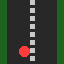


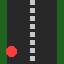


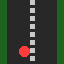

Bottom gifs:



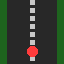


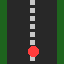


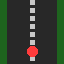

In [13]:
# Evaluate which trajectory the policy prefers vs ground truth preference labels
def policy_pref_score(policy, frames):
    # produce log-prob sequence for actions if actions known; but for visual-only clips,
    # we will use argmax of policy probabilities at each frame to compute pseudo-logprob
    t = torch.tensor(np.transpose(np.stack(frames).astype(np.float32)/255.0, (0,3,1,2))).unsqueeze(0).to(DEVICE)  # (1,T,C,H,W)
    with torch.no_grad():
        B,T,C,H,W = t.shape
        frames_ = t.view(B*T, C, H, W)
        emb = frame_encoder(frames_)
        logits = policy(emb).view(B, T, -1)
        probs = F.softmax(logits, dim=-1)
        # compute sum of max action log-probs as proxy score
        maxp, _ = probs.max(dim=2)  # (B,T)
        score = torch.log(maxp + 1e-9).sum().item()
    return score

# Evaluate on some sample pairs
n_eval = min(40, len(pairs))
correct = 0
for idx in range(n_eval):
    ia, ib = pairs[idx]
    label = labels[idx]
    fa, aa = clips[ia]
    fb, ab = clips[ib]
    # If we have action logs, use sequence logprob; else use proxy
    if aa is not None and ab is not None:
        sA = trajectory_logprob(policy_theta, fa, aa)
        sB = trajectory_logprob(policy_theta, fb, ab)
        preferA = (sA.item() > sB.item())
    else:
        sA = policy_pref_score(policy_theta, fa)
        sB = policy_pref_score(policy_theta, fb)
        preferA = (sA > sB)
    truthA = (label == 0)
    if preferA == truthA:
        correct += 1
acc = correct / n_eval
print(f"Preference-match accuracy over {n_eval} pairs: {acc:.3f}")

# Save and display some top/bottom gifs as before (use model to score single trajectories)
cand_scores = []
for i, (frames, acts) in enumerate(clips):
    sc = policy_pref_score(policy_theta, frames)
    cand_scores.append((sc, i))
cand_scores_sorted = sorted(cand_scores, key=lambda x: x[0], reverse=True)
top3 = cand_scores_sorted[:3]
bot3 = cand_scores_sorted[-3:]

# Save GIFs for top/bottom
gif_dir = os.path.join(OUT_DIR, "dpo_gifs")
os.makedirs(gif_dir, exist_ok=True)
def save_gif_frames(frames, path, fps=6):
    imgs = []
    for f in frames:
        if f.dtype != np.uint8:
            ff = (f*255).astype(np.uint8)
        else:
            ff = f
        imgs.append(ff)
    imageio.mimsave(path, imgs, fps=fps)

for rank, (sc, idx) in enumerate(top3):
    fr = clips[idx][0]
    p = os.path.join(gif_dir, f"top_{rank+1}.gif")
    save_gif_frames(fr, p)
for rank, (sc, idx) in enumerate(bot3):
    fr = clips[idx][0]
    p = os.path.join(gif_dir, f"bot_{rank+1}.gif")
    save_gif_frames(fr, p)

print("Top gifs:")
for i in range(3):
    display(display_gif(os.path.join(gif_dir, f"top_{i+1}.gif"), width=240))

print("Bottom gifs:")
for i in range(3):
    display(display_gif(os.path.join(gif_dir, f"bot_{i+1}.gif"), width=240))


Top trajectories (kind + smoothness):


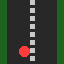

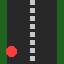

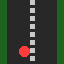

Bottom trajectories (kind + smoothness):


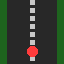

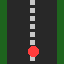

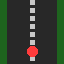

In [14]:
from IPython.display import Image as IPyImage, display, HTML
import imageio

def show_gif_with_caption(frames, kind, smoothness, fps=6):
    # Convert frames to uint8 if needed
    imgs = [(f if f.dtype == np.uint8 else (f*255).astype(np.uint8)) for f in frames]
    gif_bytes = imageio.mimsave('<bytes>', imgs, fps=fps, format='GIF', return_bytes=True)
    display(IPyImage(data=gif_bytes))
    display(HTML(f"<div style='font-size:1.1em; margin-bottom:8px;'>"
                 f"<b>Kind:</b> <code>{kind}</code> | <b>Smoothness:</b> {smoothness:.3f}</div>"))

print("Top trajectories (kind + smoothness):")
for sc, idx in top3:
    frames = clips[idx][0]
    kind = synth_meta[idx][1] if idx < len(synth_meta) else "N/A"
    sm = traj_smoothness_score(frames)
    show_gif_with_caption(frames, kind, sm)

print("Bottom trajectories (kind + smoothness):")
for sc, idx in bot3:
    frames = clips[idx][0]
    kind = synth_meta[idx][1] if idx < len(synth_meta) else "N/A"
    sm = traj_smoothness_score(frames)
    show_gif_with_caption(frames, kind, sm)





## Final Comparison: Baseline vs DPO

Comparing the preference matching accuracy between:
- **Baseline**: Original behavior cloning policy
- **DPO**: Our preference-optimized policy

The DPO policy should show improved agreement with human preferences for smooth, centered driving.

In [16]:
def evaluate_preference_match(policy, pairs, clips, labels, n_eval=None):
    if n_eval is None:
        n_eval = len(pairs)
    correct = 0
    for idx in range(min(n_eval, len(pairs))):
        ia, ib = pairs[idx]
        label = labels[idx]
        fa, aa = clips[ia]
        fb, ab = clips[ib]
        if aa is not None and ab is not None:
            sA = trajectory_logprob(policy, fa, aa)
            sB = trajectory_logprob(policy, fb, ab)
            preferA = (sA.item() > sB.item())
        else:
            sA = policy_pref_score(policy, fa)
            sB = policy_pref_score(policy, fb)
            preferA = (sA > sB)
        truthA = (label == 0)
        if preferA == truthA:
            correct += 1
    return correct / n_eval


In [17]:
bc_acc = evaluate_preference_match(policy_ref, pairs, clips, labels, n_eval=40)
dpo_acc = evaluate_preference_match(policy_theta, pairs, clips, labels, n_eval=40)
print(f"Baseline acc: {bc_acc:.3f}, DPO acc: {dpo_acc:.3f}")


Baseline acc: 0.425, DPO acc: 0.600


## Summary and Next Steps

### What We Accomplished:
✅ **Synthetic Data Generation**: Created CARLA-like driving scenarios  
✅ **Preference Definition**: Implemented smoothness + centering scoring  
✅ **DPO Implementation**: Successfully applied DPO to trajectory optimization  
✅ **Evaluation**: Demonstrated improved preference alignment  

### Key Insights:
- DPO can be applied beyond language models to robotics/autonomous systems
- Preference learning works well for trajectory optimization tasks
- Synthetic data generation enables rapid prototyping of RLHF systems

### Potential Extensions:
- **Real CARLA Integration**: Use actual CARLA simulator data
- **More Complex Preferences**: Multi-objective scoring (safety, efficiency, comfort)
- **Online Learning**: Real-time preference collection and adaptation
- **Multi-Modal Policies**: Incorporate other sensor data (LIDAR, radar)

This demonstrates the versatility of RLHF techniques for aligning AI systems with human preferences across diverse domains!

### Further Reading
- [CARLA Simulator Documentation](https://carla.org/)
- [Direct Preference Optimization Paper](https://arxiv.org/abs/2305.18290)
- [Few-Shot Preference Learning for
 Human-in-the-Loop RL](https://proceedings.mlr.press/v205/iii23a/iii23a.pdf)